# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *
from notebook import psource, show_map, final_path_colors, display_visual

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Best First Search
* Uniform Cost Search
* Greedy Best First Search
* A\* Search
* Genetic Algorithm

## OVERVIEW

Here, we learn about problem solving. Building goal-based agents that can plan ahead to solve problems, in particular, navigation problem/route finding problem. First, we will start the problem solving by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms. Broadly, search algorithms are classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
* Examples:
    1. Breadth First Search
    2. Depth First Search
    3. Depth Limited Search
    4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
* Examples:
    1. Best First Search
    2. Uniform Cost Search
    3. A\* Search
    4. Recursive Best First Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in `notebook.py`.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [3]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor` and is the first method called when you create an instance of the class. `initial` specifies the initial state of our search problem. It represents the start state from where our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Given a graph state, it checks if it is a terminal state. If the state is indeed a goal state, value of `True` is returned. Else, of course, `False` is returned.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [4]:
psource(Node)

The `Node` class has nine methods.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [5]:
psource(GraphProblem)

Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [6]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Hmm... say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [7]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [8]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

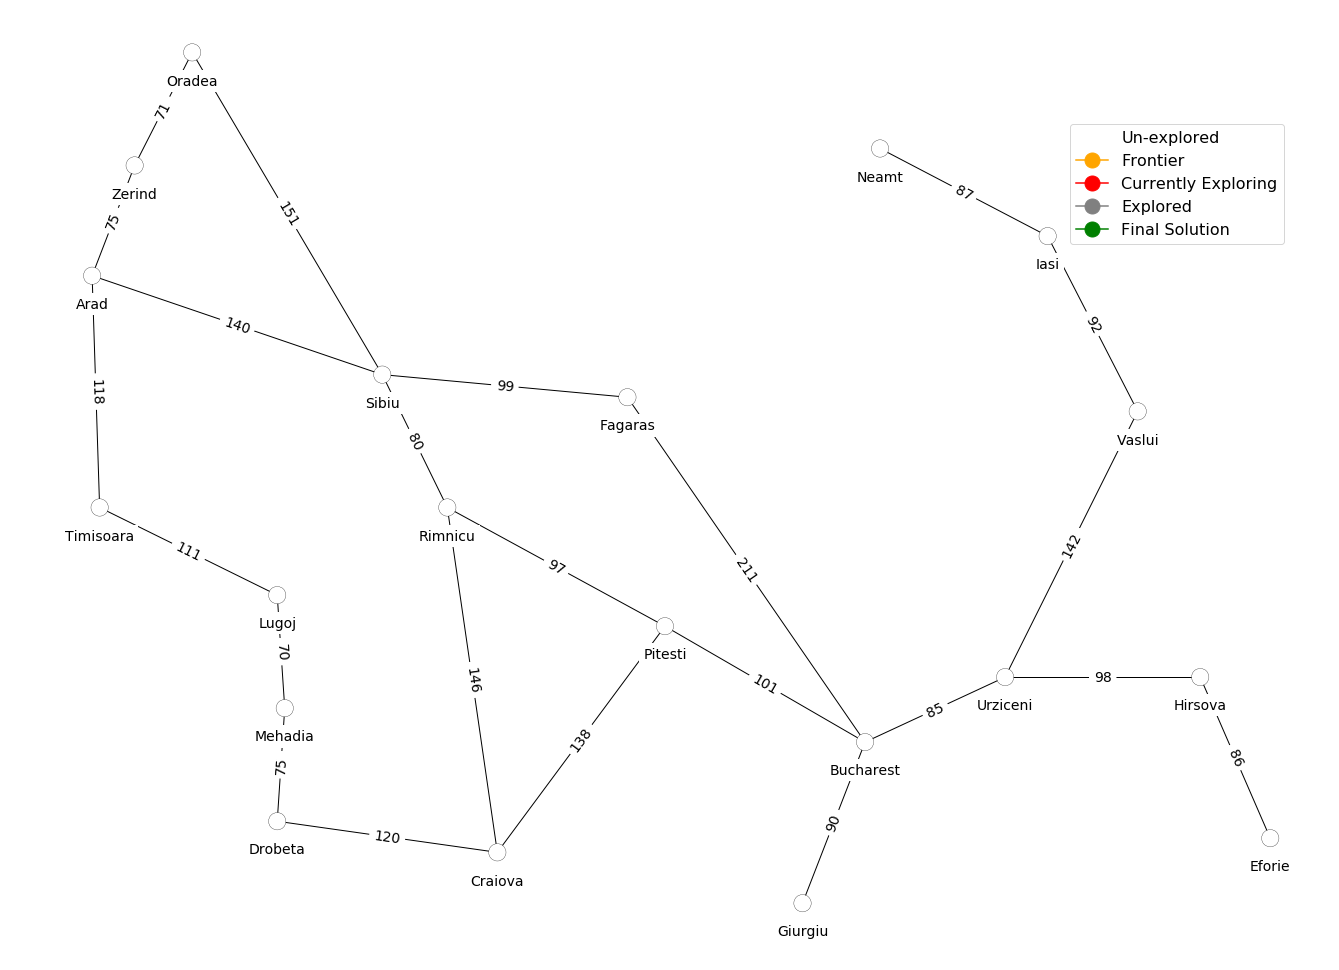

In [10]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SIMPLE PROBLEM SOLVING AGENT PROGRAM

Let us now define a Simple Problem Solving Agent Program. Run the next cell to see how the abstract class `SimpleProblemSolvingAgentProgram` is defined in the search module.

In [11]:
psource(SimpleProblemSolvingAgentProgram)

The SimpleProblemSolvingAgentProgram class has six methods:  

* `__init__(self, intial_state=None)`: This is the `contructor` of the class and is the first method to be called when the class is instantiated. It takes in a keyword argument, `initial_state` which is initially `None`. The argument `intial_state` represents the state from which the agent starts.

* `__call__(self, percept)`: This method updates the `state` of the agent based on its `percept` using the `update_state` method. It then formulates a `goal` with the help of `formulate_goal` method and a `problem` using the `formulate_problem` method and returns a sequence of actions to solve it (using the `search` method).

* `update_state(self, percept)`: This method updates the `state` of the agent based on its `percept`.

* `formulate_goal(self, state)`: Given a `state` of the agent, this method formulates the `goal` for it.

* `formulate_problem(self, state, goal)`: It is used in problem formulation given a `state` and a `goal` for the `agent`.

* `search(self, problem)`: This method is used to search a sequence of `actions` to solve a `problem`.

Let us now define a Simple Problem Solving Agent Program. We will create a simple `vacuumAgent` class which will inherit from the abstract class `SimpleProblemSolvingAgentProgram` and overrides its methods. We will create a simple intelligent vacuum agent which can be in any one of the following states. It will move to any other state depending upon the current state as shown in the picture by arrows:

![simple problem solving agent](images/simple_problem_solving_agent.jpg)

In [12]:
class vacuumAgent(SimpleProblemSolvingAgentProgram):
        def update_state(self, state, percept):
            return percept

        def formulate_goal(self, state):
            goal = [state7, state8]
            return goal  

        def formulate_problem(self, state, goal):
            problem = state
            return problem   
    
        def search(self, problem):
            if problem == state1:
                seq = ["Suck", "Right", "Suck"]
            elif problem == state2:
                seq = ["Suck", "Left", "Suck"]
            elif problem == state3:
                seq = ["Right", "Suck"]
            elif problem == state4:
                seq = ["Suck"]
            elif problem == state5:
                seq = ["Suck"]
            elif problem == state6:
                seq = ["Left", "Suck"]
            return seq

Now, we will define all the 8 states and create an object of the above class. Then, we will pass it different states and check the output:

In [13]:
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = vacuumAgent(state1)

print(a(state6)) 
print(a(state1))
print(a(state3))

Left
Suck
Right


## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:

1. Breadth First Tree Search
2. Depth First Tree Search
3. Breadth First Search
4. Depth First Graph Search
5. Best First Graph Search
6. Uniform Cost Search
7. Depth Limited Search
8. Iterative Deepening Search
9. A\*-Search
10. Recursive Best First Search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

## 1. BREADTH-FIRST TREE SEARCH

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.

In [23]:
def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the queue
    frontier.append(Node(problem.initial))
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_search(problem, FIFOQueue())
    return(iterations, all_node_colors, node)

Now, we use `ipywidgets` to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.

In [24]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Fagaras', romania_map)
a, b, c = breadth_first_tree_search(romania_problem)
display_visual(romania_graph_data, user_input = False, algorithm = breadth_first_tree_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## 2. Depth-First Tree Search:
Now let's discuss another searching algorithm, Depth-First Tree Search.

In [16]:
def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    # This algorithm might not work in case of repeated paths
    # and may run into an infinite while loop.
    iterations, all_node_colors, node = tree_search(problem, Stack())
    return(iterations, all_node_colors, node)

In [17]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Oradea', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = depth_first_tree_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## 3. BREADTH-FIRST GRAPH SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [18]:
def breadth_first_search(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = FIFOQueue()
    frontier.append(node)
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [19]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = breadth_first_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## 4. Depth-First Graph Search:  
Although we have a working implementation in search module, we have to make a few changes in the algorithm to make it suitable for visualization.

In [20]:
def graph_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier.append(Node(problem.initial))
    explored = set()
    
    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search(problem, Stack())
    return(iterations, all_node_colors, node)

In [21]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = depth_first_graph_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## 5. BEST FIRST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [25]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

## 6. UNIFORM COST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [28]:
def uniform_cost_search(problem):
    "[Figure 3.14]"
    #Uniform Cost Search uses Best First Search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)


In [29]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = uniform_cost_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## GREEDY BEST FIRST SEARCH
Let's change all the node_colors to starting position and define a different problem statement.

In [30]:
def greedy_best_first_search(problem, h=None):
    """Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
    You need to specify the h function when you call best_first_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)


In [31]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = greedy_best_first_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

## 9. A\* SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [34]:
def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)


In [35]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, algorithm = astar_search, problem = romania_problem)

A Jupyter Widget

A Jupyter Widget

In [36]:
all_node_colors = []
# display_visual(romania_graph_data, user_input = True, algorithm = breadth_first_tree_search)
display_visual(romania_graph_data, user_input = True)

NameError: name 'breadth_first_tree_search' is not defined

## A* Heuristics

Different heuristics provide different efficiency in solving A* problems which are generally defined by the number of explored nodes as well as the branching factor. With the classic 8 puzzle we can show the efficiency of different heuristics through the number of explored nodes.

### 8 Puzzle Problem

The *8 Puzzle Problem* consists of a 3x3 tray in which the goal is to get the initial configuration to the goal state by shifting the numbered tiles into the blank space.

example:- 

              Initial State                        Goal State
              | 7 | 2 | 4 |                       | 0 | 1 | 2 |
              | 5 | 0 | 6 |                       | 3 | 4 | 5 |
              | 8 | 3 | 1 |                       | 6 | 7 | 8 |
              
We have a total of 9 blank tiles giving us a total of 9! initial configuration but not all of these are solvable. The solvability of a configuration can be checked by calculating the Inversion Permutation. If the total Inversion Permutation is even then the initial configuration is solvable else the initial configuration is not solvable which means that only 9!/2 initial states lead to a solution.

#### Heuristics :-

1) Manhattan Distance:- For the 8 puzzle problem Manhattan distance is defined as the distance of a tile from its goal state( for the tile numbered '1' in the initial configuration Manhattan distance is 4 "2 for left and 2 for upward displacement").

2) No. of Misplaced Tiles:- The heuristic calculates the number of misplaced tiles between the current state and goal state.

3) Sqrt of Manhattan Distance:- It calculates the square root of Manhattan distance.

4) Max Heuristic:- It assign the score as the maximum between "Manhattan Distance" and "No. of Misplaced Tiles". 

In [37]:
# Heuristics for 8 Puzzle Problem

def linear(state,goal):
    return sum([1 if state[i] != goal[i] else 0 for i in range(8)])

def manhanttan(state,goal):
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    
    return mhd

def sqrt_manhanttan(state,goal):
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    
    return math.sqrt(mhd)

def max_heuristic(state,goal):
    score1 = manhanttan(state, goal)
    score2 = linear(state, goal)
    return max(score1, score2)

In [38]:
# Solving the puzzle 
puzzle = EightPuzzle()
puzzle.checkSolvability([2,4,3,1,5,6,7,8,0]) # checks whether the initialized configuration is solvable or not
puzzle.solve([2,4,3,1,5,6,7,8,0], [1,2,3,4,5,6,7,8,0],max_heuristic) # Max_heuristic
puzzle.solve([2,4,3,1,5,6,7,8,0], [1,2,3,4,5,6,7,8,0],linear) # Linear
puzzle.solve([2,4,3,1,5,6,7,8,0], [1,2,3,4,5,6,7,8,0],manhanttan) # Manhattan
puzzle.solve([2,4,3,1,5,6,7,8,0], [1,2,3,4,5,6,7,8,0],sqrt_manhanttan) # Sqrt_manhattan

TypeError: __init__() missing 1 required positional argument: 'initial'

## HILL CLIMBING

Hill Climbing is a heuristic search used for optimization problems.
Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. 
This solution may or may not be the global optimum.
The algorithm is a variant of generate and test algorithm. 
<br>
As a whole, the algorithm works as follows:
- Evaluate the initial state.
- If it is equal to the goal state, return.
- Find a neighboring state (one which is heuristically similar to the current state)
- Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps.
<br>

In [39]:
psource(hill_climbing)

We will find an approximate solution to the traveling salespersons problem using this algorithm.
<br>
We need to define a class for this problem.
<br>
`Problem` will be used as a base class.

In [40]:
class TSP_problem(Problem):

    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return -1 * self.path_cost(None, None, None, state)

We will use cities from the Romania map as our cities for this problem.
<br>
A list of all cities and a dictionary storing distances between them will be populated.

In [41]:
distances = {}
all_cities = []

for city in romania_map.locations.keys():
    distances[city] = {}
    all_cities.append(city)
    
all_cities.sort()
print(all_cities)

['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']


Next, we need to populate the individual lists inside the dictionary with the manhattan distance between the cities.

In [42]:
import numpy as np
for name_1, coordinates_1 in romania_map.locations.items():
        for name_2, coordinates_2 in romania_map.locations.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

The way neighbours are chosen currently isn't suitable for the travelling salespersons problem.
We need a neighboring state that is similar in total path distance to the current state.
<br>
We need to change the function that finds neighbors.

In [43]:
def hill_climbing(problem):
    
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    
    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """
        
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state
            
        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 10000
    
    current = Node(problem.initial)
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        
    return current.state

An instance of the TSP_problem class will be created.

In [44]:
tsp = TSP_problem(all_cities)

We can now generate an approximate solution to the problem by calling `hill_climbing`.
The results will vary a bit each time you run it.

In [45]:
hill_climbing(tsp)

['Fagaras',
 'Drobeta',
 'Craiova',
 'Vaslui',
 'Rimnicu',
 'Neamt',
 'Bucharest',
 'Giurgiu',
 'Eforie',
 'Sibiu',
 'Iasi',
 'Urziceni',
 'Zerind',
 'Lugoj',
 'Hirsova',
 'Oradea',
 'Arad',
 'Mehadia',
 'Pitesti',
 'Timisoara']

The solution looks like this.
It is not difficult to see why this might be a good solution.
<br>
![title](images/hillclimb-tsp.png)

## GENETIC ALGORITHM

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations was reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* Point Crossover: The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](images/point_crossover.png)

* Uniform Crossover: This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](images/uniform_crossover.png)

### Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.

### Selection

At each iteration, the fittest individuals are picked randomly to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual. Usually the higher the better.

The selection process is this:

1) Individuals are scored by the fitness function.

2) Individuals are picked randomly, according to their score (higher score means higher chance to get picked). Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

### Implementation

Below we look over the implementation of the algorithm in the `search` module.

First the implementation of the main core of the algorithm:

In [2]:
psource(genetic_algorithm)

The algorithm takes the following input:

* `population`: The initial population.

* `fitness_fn`: The problem's fitness function.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `f_thres`: The fitness threshold. If an individual reaches that score, iteration stops. By default 'None', which means the algorithm will not halt until the generations are ran.

* `ngen`: The number of iterations/generations.

* `pmut`: The probability of mutation.

The algorithm gives as output the state with the largest score.

For each generation, the algorithm updates the population. First it calculates the fitnesses of the individuals, then it selects the most fit ones and finally crosses them over to produce offsprings. There is a chance that the offspring will be mutated, given by `pmut`. If at the end of the generation an individual meets the fitness threshold, the algorithm halts and returns that individual.

The function of mating is accomplished by the method `recombine`:

In [3]:
psource(recombine)

The method picks at random a point and merges the parents (`x` and `y`) around it.

The mutation is done in the method `mutate`:

In [4]:
psource(mutate)

We pick a gene in `x` to mutate and a gene from the gene pool to replace it with.

To help initializing the population we have the helper function `init_population`":

In [5]:
psource(init_population)

The function takes as input the number of individuals in the population, the gene pool and the length of each individual/state. It creates individuals with random genes and returns the population when done.

### Explanation

Before we solve problems using the genetic algorithm, we will explain how to intuitively understand the algorithm using a trivial example.

#### Generating Phrases

In this problem, we use a genetic algorithm to generate a particular target phrase from a population of random strings. This is a classic example that helps build intuition about how to use this algorithm in other problems as well. Before we break the problem down, let us try to brute force the solution. Let us say that we want to generate the phrase "genetic algorithm". The phrase is 17 characters long. We can use any character from the 26 lowercase characters and the space character. To generate a random phrase of length 17, each space can be filled in 27 ways. So the total number of possible phrases is

$$ 27^{17} = 2153693963075557766310747 $$

which is a massive number. If we wanted to generate the phrase "Genetic Algorithm", we would also have to include all the 26 uppercase characters into consideration thereby increasing the sample space from 27 characters to 53 characters and the total number of possible phrases then would be

$$ 53^{17} = 205442259656281392806087233013 $$

If we wanted to include punctuations and numerals into the sample space, we would have further complicated an already impossible problem. Hence, brute forcing is not an option. Now we'll apply the genetic algorithm and see how it significantly reduces the search space. We essentially want to *evolve* our population of random strings so that they better approximate the target phrase as the number of generations increase. Genetic algorithms work on the principle of Darwinian Natural Selection according to which, there are three key concepts that need to be in place for evolution to happen. They are:

* **Heredity**: There must be a process in place by which children receive the properties of their parents. <br> 
For this particular problem, two strings from the population will be chosen as parents and will be split at a random index and recombined as described in the `recombine` function to create a child. This child string will then be added to the new generation.


* **Variation**: There must be a variety of traits present in the population or a means with which to introduce variation. <br>If there is no variation in the sample space, we might never reach the global optimum. To ensure that there is enough variation, we can initialize a large population, but this gets computationally expensive as the population gets larger. Hence, we often use another method called mutation. In this method, we randomly change one or more characters of some strings in the population based on a predefined probability value called the mutation rate or mutation probability as described in the `mutate` function. The mutation rate is usually kept quite low. A mutation rate of zero fails to introduce variation in the population and a high mutation rate (say 50%) is as good as a coin flip and the population fails to benefit from the previous recombinations. An optimum balance has to be maintained between population size and mutation rate so as to reduce the computational cost as well as have sufficient variation in the population.


* **Selection**: There must be some mechanism by which some members of the population have the opportunity to be parents and pass down their genetic information and some do not. This is typically referred to as "survival of the fittest". <br>
There has to be some way of determining which phrases in our population have a better chance of eventually evolving into the target phrase. This is done by introducing a fitness function that calculates how close the generated phrase is to the target phrase. The function will simply return a scalar value corresponding to the number of matching characters between the generated phrase and the target phrase.

Before solving the problem, we first need to define our target phrase.

In [33]:
target = 'Genetic Algorithm'

We then need to define our gene pool, i.e the elements which an individual from the population might comprise of. Here, the gene pool contains all uppercase and lowercase letters of the English alphabet and the space character.

In [34]:
# The ASCII values of uppercase characters ranges from 65 to 91
u_case = [chr(x) for x in range(65, 91)]
# The ASCII values of lowercase characters ranges from 97 to 123
l_case = [chr(x) for x in range(97, 123)]

gene_pool = []
gene_pool.extend(u_case) # adds the uppercase list to the gene pool
gene_pool.extend(l_case) # adds the lowercase list to the gene pool
gene_pool.append(' ')    # adds the space character to the gene pool

We now need to define the maximum size of each population. Larger populations have more variation but are computationally more  expensive to run algorithms on.

In [35]:
max_population = 100

As our population is not very large, we can afford to keep a relatively large mutation rate.

In [36]:
mutation_rate = 0.07 # 7%

Great! Now, we need to define the most important metric for the genetic algorithm, i.e the fitness function. This will simply return the number of matching characters between the generated sample and the target phrase.

In [37]:
def fitness_fn(sample):
    # initialize fitness to 0
    fitness = 0
    for i in range(len(sample)):
        # increment fitness by 1 for every matching character
        if sample[i] == target[i]:
            fitness += 1
    return fitness

Before we run our genetic algorithm, we need to initialize a random population. We will use the `init_population` function to do this. We need to pass in the maximum population size, the gene pool and the length of each individual, which in this case will be the same as the length of the target phrase.

In [38]:
population = init_population(max_population, gene_pool, len(target))

We will now define how the individuals in the population should change as the number of generations increases. First, the `select` function will be run on the population to select *two* individuals with high fitness values. These will be the parents which will then be recombined using the `recombine` function to generate the child.

In [39]:
parents = select(2, population, fitness_fn) 

In [40]:
# The recombine function takes two parents as arguments, so we need to unpack the previous variable
child = recombine(*parents)

Next, we need to apply a mutation according to the mutation rate. We call the `mutate` function on the child with the gene pool and mutation rate as the additional arguments.

In [41]:
child = mutate(child, gene_pool, mutation_rate)

The above lines can be condensed into

`child = mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate)`

And, we need to do this `for` every individual in the current population to generate the new population.

In [42]:
population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate) for i in range(len(population))]

The individual with the highest fitness can then be found using the `max` function.

In [43]:
current_best = max(population, key=fitness_fn)

Let's print this out

In [44]:
print(current_best)

['j', 'F', 'm', 'F', 'N', 'i', 'c', 'v', 'm', 'j', 'V', 'o', 'd', 'r', 't', 'V', 'H']


We see that this is a list of characters. This can be converted to a string using the join function

In [45]:
current_best_string = ''.join(current_best)
print(current_best_string)

jFmFNicvmjVodrtVH


We now need to define the conditions to terminate the algorithm. This can happen in two ways
1. Termination after a predefined number of generations
2. Termination when the fitness of the best individual of the current generation reaches a predefined threshold value.

We define these variables below

In [46]:
ngen = 1200 # maximum number of generations
# we set the threshold fitness equal to the length of the target phrase
# i.e the algorithm only terminates whne it has got all the characters correct 
# or it has completed 'ngen' number of generations
f_thres = len(target)

To generate `ngen` number of generations, we run a `for` loop `ngen` number of times. After each generation, we calculate the fitness of the best individual of the generation and compare it to the value of `f_thres` using the `fitness_threshold` function. After every generation, we print out the best individual of the generation and the corresponding fitness value. Lets now write a function to do this.

In [47]:
def genetic_algorithm_stepwise(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1200, pmut=0.1):
    for generation in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut) for i in range(len(population))]
        # stores the individual genome with the highest fitness in the current population
        current_best = ''.join(max(population, key=fitness_fn))
        print(f'Current best: {current_best}\t\tGeneration: {str(generation)}\t\tFitness: {fitness_fn(current_best)}\r', end='')
        
        # compare the fitness of the current best individual to f_thres
        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        
        # if fitness is greater than or equal to f_thres, we terminate the algorithm
        if fittest_individual:
            return fittest_individual, generation
    return max(population, key=fitness_fn) , generation       

The function defined above is essentially the same as the one defined in `search.py` with the added functionality of printing out the data of each generation.

In [48]:
psource(genetic_algorithm)

We have defined all the required functions and variables. Let's now create a new population and test the function we wrote above.

In [49]:
population = init_population(max_population, gene_pool, len(target))
solution, generations = genetic_algorithm_stepwise(population, fitness_fn, gene_pool, f_thres, ngen, mutation_rate)

The genetic algorithm was able to converge!
We implore you to rerun the above cell and play around with `target, max_population, f_thres, ngen` etc parameters to get a better intuition of how the algorithm works. To summarize, if we can define the problem states in simple array format and if we can create a fitness function to gauge how good or bad our approximate solutions are, there is a high chance that we can get a satisfactory solution using a genetic algorithm. 
- There is also a better GUI version of this program `genetic_algorithm_example.py` in the GUI folder for you to play around with.

### Usage

Below we give two example usages for the genetic algorithm, for a graph coloring problem and the 8 queens problem.

#### Graph Coloring

First we will take on the simpler problem of coloring a small graph with two colors. Before we do anything, let's imagine how a solution might look. First, we have to represent our colors. Say, 'R' for red and 'G' for green. These make up our gene pool. What of the individual solutions though? For that, we will look at our problem. We stated we have a graph. A graph has nodes and edges, and we want to color the nodes. Naturally, we want to store each node's color. If we have four nodes, we can store their colors in a list of genes, one for each node. A possible solution will then look like this: ['R', 'R', 'G', 'R']. In the general case, we will represent each solution with a list of chars ('R' and 'G'), with length the number of nodes.

Next we need to come up with a fitness function that appropriately scores individuals. Again, we will look at the problem definition at hand. We want to color a graph. For a solution to be optimal, no edge should connect two nodes of the same color. How can we use this information to score a solution? A naive (and ineffective) approach would be to count the different colors in the string. So ['R', 'R', 'R', 'R'] has a score of 1 and ['R', 'R', 'G', 'G'] has a score of 2. Why that fitness function is not ideal though? Why, we forgot the information about the edges! The edges are pivotal to the problem and the above function only deals with node colors. We didn't use all the information at hand and ended up with an ineffective answer. How, then, can we use that information to our advantage?

We said that the optimal solution will have all the edges connecting nodes of different color. So, to score a solution we can count how many edges are valid (aka connecting nodes of different color). That is a great fitness function!

Let's jump into solving this problem using the `genetic_algorithm` function.

First we need to represent the graph. Since we mostly need information about edges, we will just store the edges. We will denote edges with capital letters and nodes with integers:

In [6]:
edges = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

Edge 'A' connects nodes 0 and 1, edge 'B' connects nodes 0 and 3 etc.

We already said our gene pool is 'R' and 'G', so we can jump right into initializing our population. Since we have only four nodes, `state_length` should be 4. For the number of individuals, we will try 8. We can increase this number if we need higher accuracy, but be careful! Larger populations need more computating power and take longer. You need to strike that sweet balance between accuracy and cost (the ultimate dilemma of the programmer!).

In [7]:
population = init_population(8, ['R', 'G'], 4)
print(population)

[['R', 'G', 'G', 'R'], ['R', 'G', 'R', 'R'], ['G', 'R', 'G', 'R'], ['R', 'G', 'R', 'G'], ['G', 'R', 'R', 'G'], ['G', 'R', 'G', 'R'], ['G', 'R', 'R', 'R'], ['R', 'G', 'G', 'G']]


We created and printed the population. You can see that the genes in the individuals are random and there are 8 individuals each with 4 genes.

Next we need to write our fitness function. We previously said we want the function to count how many edges are valid. So, given a coloring/individual `c`, we will do just that:

In [8]:
def fitness(c):
    return sum(c[n1] != c[n2] for (n1, n2) in edges.values())

Great! Now we will run the genetic algorithm and see what solution it gives.

In [9]:
solution = genetic_algorithm(population, fitness, gene_pool=['R', 'G'])
print(solution)

['R', 'G', 'R', 'G']


The algorithm converged to a solution. Let's check its score:

In [10]:
print(fitness(solution))

4


The solution has a score of 4. Which means it is optimal, since we have exactly 4 edges in our graph, meaning all are valid!

*NOTE: Because the algorithm is non-deterministic, there is a chance a different solution is given. It might even be wrong, if we are very unlucky!*

#### Eight Queens

Let's take a look at a more complicated problem.

In the *Eight Queens* problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others (aka queens should not be in the same row, column or diagonal). In its general form the problem is defined as placing *N* queens in an NxN chessboard without any conflicts.

First we need to think about the representation of each solution. We can go the naive route of representing the whole chessboard with the queens' placements on it. That is definitely one way to go about it, but for the purpose of this tutorial we will do something different. We have eight queens, so we will have a gene for each of them. The gene pool will be numbers from 0 to 7, for the different columns. The *position* of the gene in the state will denote the row the particular queen is placed in.

For example, we can have the state "03304577". Here the first gene with a value of 0 means "the queen at row 0 is placed at column 0", for the second gene "the queen at row 1 is placed at column 3" and so forth.

We now need to think about the fitness function. On the graph coloring problem we counted the valid edges. The same thought process can be applied here. Instead of edges though, we have positioning between queens. If two queens are not threatening each other, we say they are at a "non-attacking" positioning. We can, therefore, count how many such positionings are there.

Let's dive right in and initialize our population:

In [11]:
population = init_population(100, range(8), 8)
print(population[:5])

[[0, 2, 7, 1, 7, 3, 2, 4], [2, 7, 5, 4, 4, 5, 2, 0], [7, 1, 6, 0, 1, 3, 0, 2], [0, 3, 6, 1, 3, 0, 5, 4], [0, 4, 6, 4, 7, 4, 1, 6]]


We have a population of 100 and each individual has 8 genes. The gene pool is the integers from 0 to 7, in string form. Above you can see the first five individuals.

Next we need to write our fitness function. Remember, queens threaten each other if they are at the same row, column or diagonal.

Since positionings are mutual, we must take care not to count them twice. Therefore for each queen, we will only check for conflicts for the queens after her.

A gene's value in an individual `q` denotes the queen's column, and the position of the gene denotes its row. We can check if the aforementioned values between two genes are the same. We also need to check for diagonals. A queen *a* is in the diagonal of another queen, *b*, if the difference of the rows between them is equal to either their difference in columns (for the diagonal on the right of *a*) or equal to the negative difference of their columns (for the left diagonal of *a*). Below is given the fitness function.

In [12]:
def fitness(q):
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1+1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2

            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1

    return non_attacking

Note that the best score achievable is 28. That is because for each queen we only check for the queens after her. For the first queen we check 7 other queens, for the second queen 6 others and so on. In short, the number of checks we make is the sum 7+6+5+...+1. Which is equal to 7\*(7+1)/2 = 28.

Because it is very hard and will take long to find a perfect solution, we will set the fitness threshold at 25. If we find an individual with a score greater or equal to that, we will halt. Let's see how the genetic algorithm will fare.

In [16]:
solution = genetic_algorithm(population, fitness, f_thres=25, gene_pool=range(8))
print(solution)
print(fitness(solution))

[5, 0, 6, 3, 7, 4, 1, 3]
26


Above you can see the solution and its fitness score, which should be no less than 25.

With that this tutorial on the genetic algorithm comes to an end. Hope you found this guide helpful!